In [1]:
import numpy as np
import scipy as sp
import scipy.io as sio
import skimage.io as skio
import skimage
import matplotlib.pyplot as plt

In [2]:
# read the txt file for the homogeneous 2D coordinates in both images
# filename is the directory to the txt file, first line number of points rest coordinates of pts
def get_data_from_txt_file_mine(filename):
    with open(filename) as f:
        lines = f.read().split()
    num_pts = int(lines[0])
    nonhomogeneous_points = np.array([float(l) for l in lines[1:]]).reshape(-1,2)
    points = np.pad(nonhomogeneous_points[:,::-1], [(0,0),(0,1)], constant_values=1.)
    return points

In [3]:
"While reading the 2D points, first element treated as y, second as x"
def get_data_from_txt_file(filename, use_subset = False):
    with open(filename) as f:
            lines = f.read().splitlines()
    number_pts = int(lines[0])

    points = np.ones((number_pts, 3))
    for i in range(number_pts):
        split_arr = lines[i+1].split()
        if len(split_arr) == 2:
            y, x = split_arr
        else:
            x, y, z = split_arr
            points[i,2] = z
        points[i,0] = x 
        points[i,1] = y
    return points

### 1. Fundamental Matrix Estimation From Point Correspondences

In [4]:
"""
General framework for determining Fundamental matrix with 8 point algorithms
1. Get 8 corresponding points' 2D homogeneous coordinate on both images
2. reformulate the constraint to treat F as a unknown vector f in linear system
3. use SVD to obtain least square unit norm solution for f
4. reconstruct F from f, construct best rank-2 approximation of F as solution
5. best rank-2 approximation of F is done through SVD
"""
data_dir = '/Users/yuf/Desktop/class material/CS231a-3Drecon/Assignment/P2/ps2/data'
im_set = data_dir + '/set1'
im_set1 = data_dir + '/set2'

#### (a) standard 8-point algorithms for determining Fundamental matrix

In [86]:
def lls_8points_fundamental(points1,points2):
    # reformulate the constraint to treat F as f and obtain linear system W @ f = 0
    "here is the major difference: the way we compute W"
    W = np.repeat(points1,3,axis=1) * np.tile(points2,(1,3))
    #W = np.repeat(points2,3,axis=1) * np.tile(points1,(1,3))
    # use SVD to obtain least square unit norm solution for f
    u,sig,vt = np.linalg.svd(W)
    f = vt[-1]
    # reconstruct F from f, construct best rank-2 approximation of F as solution
    F_hat = f.reshape(3,3)
    u,sig,vt = np.linalg.svd(F_hat)
    sig[-1] = 0.0
    F = sig  * u @ vt
    return F
# read the txt file for the homogeneous 2D coordinates in both images: we have 37 pairs
points1 = get_data_from_txt_file(im_set+'/pt_2D_1.txt')
points2 = get_data_from_txt_file(im_set+'/pt_2D_2.txt')
F = lls_8points_fundamental(points1,points2)
print('For Dataset1, Standard 8-point algorithm obtain F as\n',F,'\n')

points1 = get_data_from_txt_file(im_set1+'/pt_2D_1.txt')
points2 = get_data_from_txt_file(im_set1+'/pt_2D_2.txt')
F = lls_8points_fundamental(points1,points2)
print('For Dataset2, Standard 8-point algorithm obtain F as\n',F)

For Dataset1, Standard 8-point algorithm obtain F as
 [[ 1.55218081e-06 -5.86997052e-06 -3.52312036e-03]
 [-8.18161523e-06 -3.02892219e-07  1.41453881e-02]
 [-1.50440111e-03 -1.13607605e-02  9.99828068e-01]] 

For Dataset2, Standard 8-point algorithm obtain F as
 [[-5.63087200e-06 -2.77622828e-05  1.07623595e-02]
 [ 2.74976583e-05 -6.74748522e-06 -1.22519240e-02]
 [-6.42650411e-03  1.52182033e-02 -9.99730547e-01]]


#### (b) normalized 8-point algorithms to determine Fundamental matrix

In [89]:
def normalized_eight_point_fundamental(points1, points2):
    # 1. obtain center value
    center1 = np.mean(points1[:,:2],axis=0)
    pts1 = points1[:,:2]-center1
    center2 = np.mean(points2[:,:2],axis=0)
    pts2 = points2[:,:2]-center2
    # 2. re-scale factor
    factor1 = np.sqrt(2/np.mean(np.sum(pts1**2,axis=1)))
    factor2 = np.sqrt(2/np.mean(np.sum(pts2**2,axis=1)))
    # 3. construct transition matrix T
    T1 = np.array([[factor1, 0., -center1[0]*factor1],
                   [0., factor1, -center1[1]*factor1],
                   [0.,       0.,                 1.]])
    T2 = np.array([[factor2, 0., -center2[0]*factor2],
                   [0., factor2, -center2[1]*factor2],
                   [0.,       0.,                 1.]])
    # 4. convert to P2 coordinate
    pts1 = (T1@(points1.T)).T
    pts2 = (T2@(points2.T)).T
    # 5. Apply standard lls 8-pts algorithm to determine Fundamental matrix
    Fq = lls_8points_fundamental(pts1,pts2)
    # 6. re_normalize on Fq to obtain F
    "Note that this expression has TYPO in lecture note"
    F = T1.T @ Fq @ T2
    return F

# Data-set 1
points1 = get_data_from_txt_file(im_set+'/pt_2D_1.txt')
points2 = get_data_from_txt_file(im_set+'/pt_2D_2.txt')
F = normalized_eight_point_fundamental(points1,points2)
print('For Dataset1, Normalized 8-point algorithm obtain F as\n',F,'\n')

# Data-set 2
points1 = get_data_from_txt_file(im_set1+'/pt_2D_1.txt')
points2 = get_data_from_txt_file(im_set1+'/pt_2D_2.txt')
F = normalized_eight_point_fundamental(points1,points2)
print('For Dataset2, Normalized 8-point algorithm obtain F as\n',F)

For Dataset1, Normalized 8-point algorithm obtain F as
 [[ 6.52113484e-07 -4.91237449e-06 -8.56136054e-04]
 [-5.33615067e-06 -3.40420428e-07  8.84208000e-03]
 [ 8.80860210e-05 -6.43807393e-03  1.45953063e-01]] 

For Dataset2, Normalized 8-point algorithm obtain F as
 [[-1.51007608e-07  3.63462620e-06  2.36155133e-04]
 [ 2.51618737e-06  3.22311660e-07 -8.53003408e-03]
 [-1.56134009e-04  7.02588719e-03 -2.45880925e-03]]


#### (c) plot epipolar lines on images

In [90]:
def plot_epipolar_lines_on_images_mine(points1, points2, img1, img2, F):
    # get corresponding lines on each 'other' image
    lines1 = (F @ points2.T).T
    lines2 = (F.T @ points1.T).T
    # in order to plot the lines, we use two specific points: (x,y) when x=0 and x=width
    w1,h1 = img1.shape 
    num_pts = points1.shape[0]
    y1 = np.tile([0.,w1], (num_pts,1))
    x1 = np.vstack((-lines1[:,2]/lines1[:,0], - (lines1[:,2]+w1*lines1[:,1])/lines1[:,0])).T
    w2,h2 = img2.shape 
    y2 = np.tile([0.,w2], (num_pts,1))
    x2 = np.vstack((-lines2[:,2]/lines2[:,0], - (lines2[:,2]+w2*lines2[:,1])/lines2[:,0])).T
    # make the plot
    fig,ax = plt.subplots(ncols=2, figsize=(12,5))
    ax[0].imshow(img1,'gray')
    ax[0].set_xlim([0,w1])
    ax[0].set_ylim([h1,0])
    ax[1].set_xlim([0,w2])
    ax[1].set_ylim([h2,0])
    ax[1].imshow(img2,'gray')
    ax[0].scatter(points1[:,0],points1[:,1],marker='*')
    ax[1].scatter(points2[:,0],points2[:,1],marker='*')
    for i in range(num_pts):
        ax[0].plot(x1[i],y1[i],'r')
        ax[1].plot(x2[i],y2[i],'r')

Epipolar Lines from 8-point algorithm estimated Fundamental Matrix:
Epipolar Lines from normalized 8-point algorithm estimated Fundamental Matrix:
For Fundamental matrix obtained by 8-points Algorithm:
Average distance between points in image 1 to its corresponding epipolar line is 28.02566293752544
Average distance between points in image 2 to its corresponding epipolar line is 25.16287580003033 

For Fundamental matrix obtained by normalized 8-points Algorithm:
Average distance between points in image 1 to its corresponding epipolar line is 0.8906416272438852
Average distance between points in image 2 to its corresponding epipolar line is 0.828772911822191


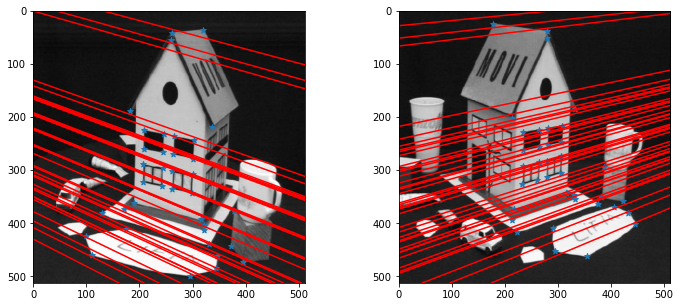

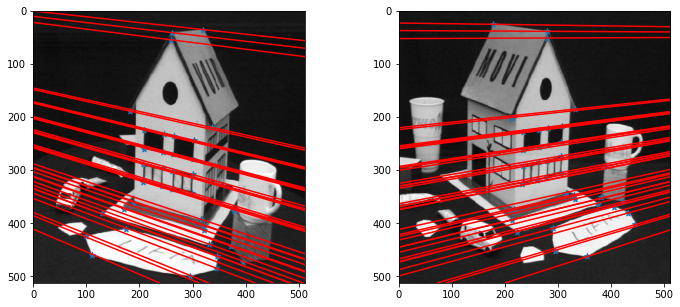

In [107]:
# Dataset1 plot
# read image files
img1 = skio.imread(im_set+'/image1.jpg')
img2 = skio.imread(im_set+'/image2.jpg')
# read the txt file for the homogeneous 2D coordinates in both images: we have 37 pairs
points1 = get_data_from_txt_file(im_set+'/pt_2D_1.txt')
points2 = get_data_from_txt_file(im_set+'/pt_2D_2.txt')
# standard 8-point algorithm
F = lls_8points_fundamental(points1,points2)
# make the plot
print('Epipolar Lines from 8-point algorithm estimated Fundamental Matrix:')
plot_epipolar_lines_on_images_mine(points1,points2,img1,img2,F)
# normalize 8-point algorithm
F_n = normalized_eight_point_fundamental(points1,points2)
# make the plot
print('Epipolar Lines from normalized 8-point algorithm estimated Fundamental Matrix:')
plot_epipolar_lines_on_images_mine(points1,points2,img1,img2,F_n)

d1,d2 = compute_distance_to_epipolar_lines(points1,points2,F)
print('For Fundamental matrix obtained by 8-points Algorithm:')
print('Average distance between points in image 1 to its corresponding epipolar line is',d1)
print('Average distance between points in image 2 to its corresponding epipolar line is',d2, '\n')
d1,d2 = compute_distance_to_epipolar_lines(points1,points2,F_n)
print('For Fundamental matrix obtained by normalized 8-points Algorithm:')
print('Average distance between points in image 1 to its corresponding epipolar line is',d1)
print('Average distance between points in image 2 to its corresponding epipolar line is',d2)

Epipolar Lines from 8-point algorithm estimated Fundamental Matrix:
Epipolar Lines from normalized 8-point algorithm estimated Fundamental Matrix:
For Fundamental matrix obtained by 8-points Algorithm:
Average distance between points in image 1 to its corresponding epipolar line is 9.701438829418564
Average distance between points in image 2 to its corresponding epipolar line is 14.56822719046507 

For Fundamental matrix obtained by normalized 8-points Algorithm:
Average distance between points in image 1 to its corresponding epipolar line is 0.889513454056867
Average distance between points in image 2 to its corresponding epipolar line is 0.8917343723800001


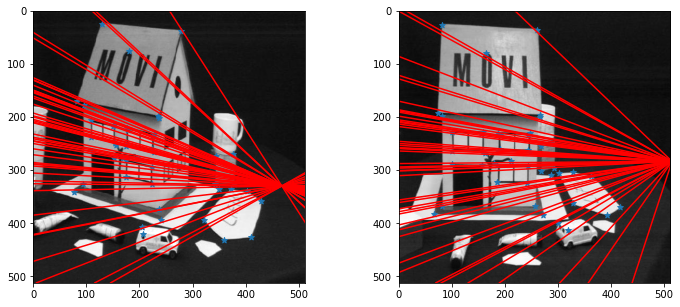

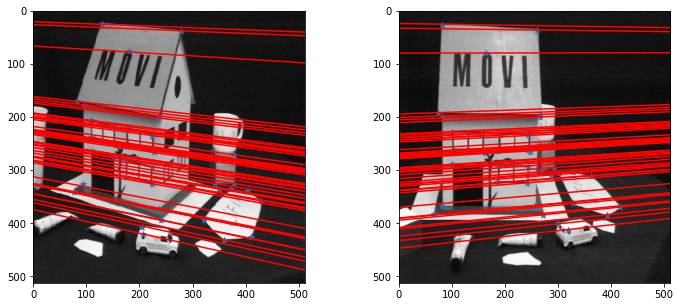

In [108]:
# Dataset2 plot
# read image files
img1 = skio.imread(im_set1+'/image1.jpg', as_gray=True)
img2 = skio.imread(im_set1+'/image2.jpg', as_gray=True)
# read the txt file for the homogeneous 2D coordinates in both images: we have 37 pairs
points1 = get_data_from_txt_file(im_set1+'/pt_2D_1.txt')
points2 = get_data_from_txt_file(im_set1+'/pt_2D_2.txt')
# standard 8-point algorithm
F = lls_8points_fundamental(points1,points2)
# make the plot
print('Epipolar Lines from 8-point algorithm estimated Fundamental Matrix:')
plot_epipolar_lines_on_images_mine(points1,points2,img1,img2,F)
# normalize 8-point algorithm
F_n = normalized_eight_point_fundamental(points1,points2)
# make the plot
print('Epipolar Lines from normalized 8-point algorithm estimated Fundamental Matrix:')
plot_epipolar_lines_on_images_mine(points1,points2,img1,img2,F_n)

d1,d2 = compute_distance_to_epipolar_lines(points1,points2,F)
print('For Fundamental matrix obtained by 8-points Algorithm:')
print('Average distance between points in image 1 to its corresponding epipolar line is',d1)
print('Average distance between points in image 2 to its corresponding epipolar line is',d2, '\n')
d1,d2 = compute_distance_to_epipolar_lines(points1,points2,F_n)
print('For Fundamental matrix obtained by normalized 8-points Algorithm:')
print('Average distance between points in image 1 to its corresponding epipolar line is',d1)
print('Average distance between points in image 2 to its corresponding epipolar line is',d2)

#### (d) Compute average distance from points to their corresponding Epipolar lines

In [78]:
def compute_distance_to_epipolar_lines(points1, points2, F):
    # get corresponding lines on each 'other' image
    lines1 = (F @ points2.T).T
    lines2 = (F.T @ points1.T).T
    # compute the distance
    dist1 = abs(np.sum(lines1*points1,axis=1)) / np.sqrt(lines1[:,0]**2 + lines1[:,1]**2)
    dist2 = abs(np.sum(lines2*points2,axis=1)) / np.sqrt(lines2[:,0]**2 + lines2[:,1]**2)
    # avg distance 
    avg_dist1 = np.mean(dist1)
    avg_dist2 = np.mean(dist2)
    return avg_dist1, avg_dist2